## Problem statement 

Describe your four questions. Articulate your questions using absolutely no jargon. 

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

After inspecting the "Geographic Cluster Name" column in the MCMF dataset, I found that there are 121,359 missing values for in-person programs. Since both analysis 1 and 2 relies heavily on information about the neighborhood programs belong to, I decided to use the geographic information in Community Boundaries dataset and latitude longtitude information in the MCMF dataset to map programs into respective neighborhoods. 

I first compared the neighborhood names in the MCMF dataset with neighborhood names in the Community Boundaries dataset to see if there are any difference. I found that aside from neighborhood names, some programs in the MCMF dataset used unstandardized names such as "Far South Equity Zone" and "Back of the Yards", which also need to be mapped. After extracting programs that has both longitude and latittude information and don't have a geographic cluster name or its geographic cluster name is unstandardized, I turned longitude lattitude information into shapely library point format. I also turned the multipolygon in Community Boundaries dataset into shapely format. Next, for each longitude-latitude pair, I checked if it is in any of the multipolygon that represents a neighborhood. 

After mapping, I reviewed the neighborhoods assigned to programs with unstandardized names. This step was necessary because some programs with unstandardized names lack latitude-longitude data, and I wanted to map them to the same neighborhoods as others with the same unstandardized name. However, upon review, I found that many unstandardized names, such as equity zones, were mapped to different neighborhood names. To avoid inconsistencies—where some equity zones are converted into neighborhood names while others remain unchanged—I decided to create a new column, "Neighborhood," dedicated exclusively to neighborhood names. Programs in equity zones that could not be mapped to a specific neighborhood will be marked as "NA" in this column.

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

### Analysis 2: How has the availability of equity-focused features among programs changed over time based on neighborhood Socioeconomic status?
*By Luna Xu*

In [2]:
#| echo: false
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from collections import Counter

#### Program Distributions

To explore this question, I began by reviewing all columns in the "My Chi My Future" (MCMF) dataset to identify those relevant to equity-focused measures. I identified "Scholarship Available," "Participants Paid," "Transport Provided," and "Has Free Food" as key equity-related features. Since Analysis 4 will specifically focus on transportation, I narrowed the scope of equity-focused features to: "Scholarship Available," "Participants Paid," and "Has Free Food."

To understand neighborhood socioeconomic status(SES), I examined the Census dataset. Since the hardship index incorporates six selected socioeconomic indicators, I decided to base my analysis on it, as it provides the most holisitic view. The hardship index functions like a ranking, with each neighborhood having a unique score, where 99 represents the highest level of hardship and 1 the lowest. Therefore, I decided to bin neighborhood into three equal buckets: low-SES, mid-SES, and high-SES. I also dropped the row "chicago" which is a total measure.

After merging the Census dataset with the SES bins and the MCMF dataset on the neighborhood variable, I explored the overall program distributions by neighborhood SES. Specifically, I counted the number of distinct programs over the years in each neighborhood and visualized them on the Chicago map using GeoPandas and Matplotlib's pyplot. Noticing several extreme values (e.g., one neighborhood had only 6 programs), I applied the LogNorm function from Matplotlib's colors module for better visualization, using the minimum and maximum program counts across all neighborhoods.

In [3]:
#| echo: false
# Reading Data
project_data = pd.read_csv('My_CHI._My_Future._Programs_20241113.csv')
chi_nei=pd.read_csv('CommAreas_20241114.csv')

# Exclude Online Program
project_data['Geographic Cluster Name'] = project_data.apply(
    lambda row: 'online' if row['Meeting Type'] == 'online' and pd.isnull(row['Geographic Cluster Name']) else row['Geographic Cluster Name'],
    axis=1
)

# Comparing Geographic Cluster Names and neighborhoodNames in Community Boundaries
project_data_unique = project_data['Geographic Cluster Name'].unique()
chi_nei_unique = chi_nei['COMMUNITY'].unique()
matches = set(project_data_unique).intersection(chi_nei_unique)
unmatched_project_data = set(project_data_unique) - matches
unmatched_chi_nei = set(chi_nei_unique) - matches
# print(f"Matches: {matches}")
# print(f"Unmatched in project_data: {unmatched_project_data}")
# print(f"Unmatched in chi_nei: {unmatched_chi_nei}")

# Extracting Programs with No Geographic Cluster Name or Unstandardized Name
unmatched_geocluster_list = list(unmatched_project_data)
project_withlatlong=project_data.loc[
    ((project_data['Geographic Cluster Name'].isnull()) | (project_data['Geographic Cluster Name'].isin(unmatched_geocluster_list))) & 
    (project_data['Latitude'].notnull()) & 
    (project_data['Longitude'].notnull()),
    ['Program ID','Latitude','Longitude','Geographic Cluster Name']
]

# Turning data into shapely format & Mapping 
project_withlatlong['point_geom']=project_withlatlong.apply(
    lambda row: Point(row['Longitude'],row['Latitude']),axis=1
)
chi_nei['shapely_geom']=chi_nei['the_geom'].apply(wkt.loads)
def match_multiploygon(point,multipolygons):
    for muultipolygon in multipolygons:
        if muultipolygon.contains(point):
            return muultipolygon
    return None
project_withlatlong['shapely_geom']=project_withlatlong['point_geom'].apply(
    lambda point: match_multiploygon(point,chi_nei['shapely_geom'])
)
matched_program_neiname = pd.merge(project_withlatlong,chi_nei,how='left')

# Checking Unstandardized Name & the Neighborhood They Mapped to
# print(matched_program_neiname.groupby('Geographic Cluster Name')['COMMUNITY'].unique())

# Result, imputed dataset
attempt1_result = matched_program_neiname.loc[matched_program_neiname['COMMUNITY'].notnull(),['Program ID','COMMUNITY']]
project_data = pd.merge(project_data,attempt1_result,on='Program ID',how='left')
project_data['Neighborhood'] = project_data.apply(
    lambda row: row['COMMUNITY'] if pd.notnull(row['COMMUNITY']) else row['Geographic Cluster Name'],
    axis=1
)
project_data.loc[project_data['Neighborhood'].isin(unmatched_geocluster_list),'Neighborhood']= None
project_data.loc[project_data['Geographic Cluster Name']=='online',['Neighborhood']]= 'online'
project_data=project_data.drop(columns=['COMMUNITY'])

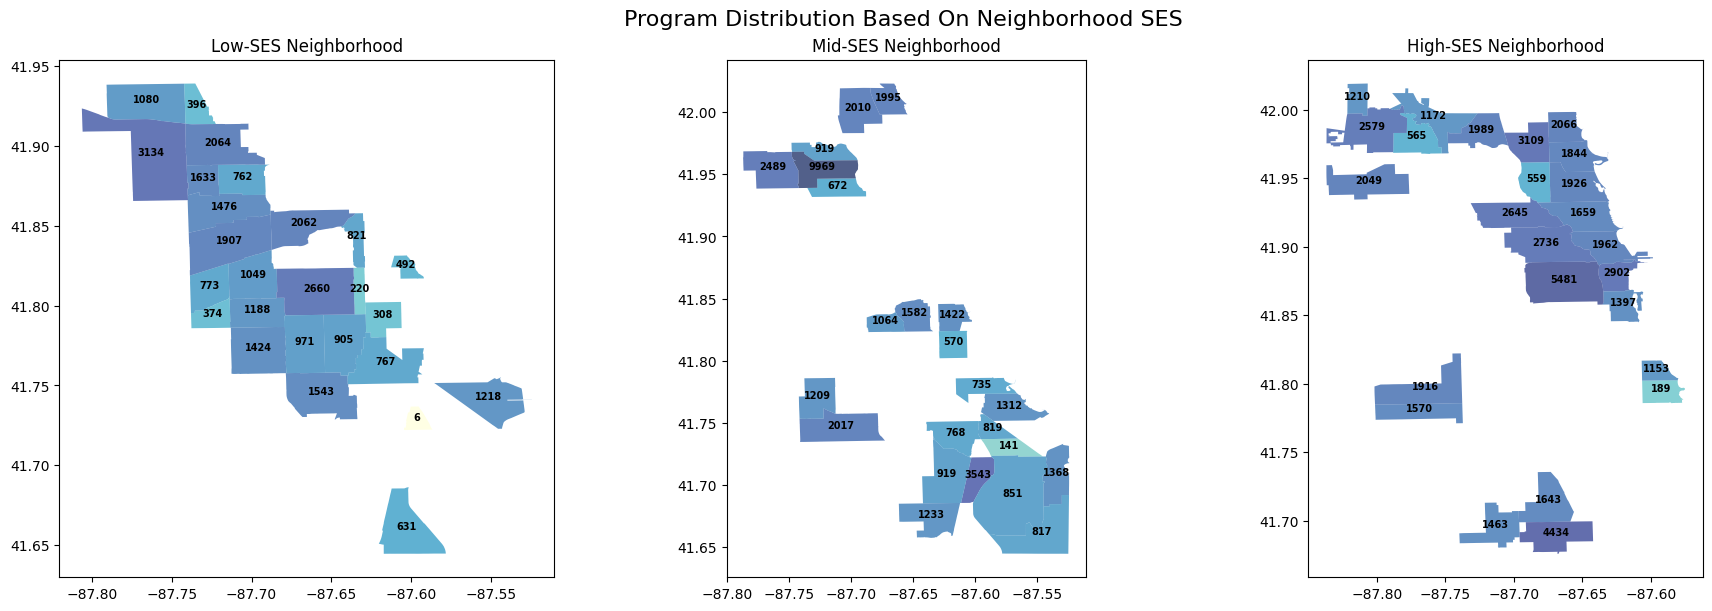

In [4]:
#| echo: false
# #Creating three socioeconomic status bins
chi_ses = pd.read_csv('Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')
chi_ses['ses_bin'] = pd.cut(chi_ses['HARDSHIP INDEX'],3,labels=['High-SES','Mid-SES','Low-SES'])
chi_ses=chi_ses[chi_ses['COMMUNITY AREA NAME']!='CHICAGO']#drop chicago total measure

#Creating Start Year Variable from Start Date 
project_data['Start Date']=pd.to_datetime(project_data['Start Date'],format='%m/%d/%Y')
project_data['Start Year']=project_data['Start Date'].dt.year

# merge census dataset with MCMF dataset
project_ses=pd.merge(project_data,chi_ses,left_on='Neighborhood',right_on='COMMUNITY AREA NAME',how='left')
# filter MCMF in-person programs with neighborhood info
project_hasnei_ses=project_ses.loc[project_ses['Neighborhood'].notnull() & (project_ses['Neighborhood']!='online')] 
# merge census dataset with neighborhood boundary dataset
chi_ses['COMMUNITY AREA NAME']=chi_ses['COMMUNITY AREA NAME'].astype(str).str.upper()
chi_nei_ses=pd.merge(chi_nei,chi_ses,left_on='COMMUNITY',right_on='COMMUNITY AREA NAME')
# create geopandas dataset
chi_nei_ses_gdf=gpd.GeoDataFrame(chi_nei_ses,geometry='shapely_geom')
# count number of distinct programs by neighborhood
program_counts = project_hasnei_ses.groupby('Neighborhood')['Program ID'].nunique().reset_index()
program_counts['Program Count']=program_counts['Program ID']
program_counts['Program Count']=program_counts['Program Count'].fillna(0)
# merge program count with neighborhood geographic & ses information
program_count_nei=pd.merge(program_counts,chi_nei_ses_gdf,left_on='Neighborhood',right_on='COMMUNITY')
# create geopandas dataset of the previous dataset
program_count_nei_gdf=gpd.GeoDataFrame(program_count_nei,geometry='shapely_geom')
# slice dataset by ses
lowses=program_count_nei_gdf.loc[program_count_nei_gdf['ses_bin']=='Low-SES',:]
midses=program_count_nei_gdf.loc[program_count_nei_gdf['ses_bin']=='Mid-SES',:]
highses=program_count_nei_gdf.loc[program_count_nei_gdf['ses_bin']=='High-SES',:]
#geospatial plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
# Plot for low SES neighborhood
lowses.plot(ax=axes[0], column='Program Count', cmap='YlGnBu', 
            norm=LogNorm(vmin=program_count_nei_gdf['Program Count'].min(), 
                         vmax=program_count_nei_gdf['Program Count'].max()), 
            alpha=0.7)
for idx, row in lowses.iterrows():
    centroid = row['shapely_geom'].centroid
    axes[0].annotate(text=int(row['Program Count']),
                     xy=(centroid.x, centroid.y),
                     fontsize=7, ha='center', color='black', fontweight='bold')
axes[0].set_title('Low-SES Neighborhood')
# Plot for mid SES neighborhood
midses.plot(ax=axes[1], column='Program Count', cmap='YlGnBu', 
            norm=LogNorm(vmin=program_count_nei_gdf['Program Count'].min(), 
                         vmax=program_count_nei_gdf['Program Count'].max()), 
            alpha=0.7)
for idx, row in midses.iterrows():
    centroid = row['shapely_geom'].centroid
    axes[1].annotate(text=int(row['Program Count']),
                     xy=(centroid.x, centroid.y),
                     fontsize=7, ha='center', color='black', fontweight='bold')
axes[1].set_title('Mid-SES Neighborhood')
# Plot for high SES neighborhood
highses.plot(ax=axes[2], column='Program Count', cmap='YlGnBu', 
             norm=LogNorm(vmin=program_count_nei_gdf['Program Count'].min(), 
                          vmax=program_count_nei_gdf['Program Count'].max()), 
             alpha=0.7)
for idx, row in highses.iterrows():
    centroid = row['shapely_geom'].centroid
    axes[2].annotate(text=int(row['Program Count']),
                     xy=(centroid.x, centroid.y),
                     fontsize=7, ha='center', color='black', fontweight='bold')
axes[2].set_title('High-SES Neighborhood')
fig.suptitle('Program Distribution Based On Neighborhood SES', fontsize=16)
plt.show()

As seen from above graphs, we can see that while there's less obvious contrasts between the three SES bins, low-SES buckets generally have more neighborhoods with less programs, including neighborhood like Bunrside that only has 6 programs over 5 years period. 

To further explore the program distributions among the three SES buckets, I plotted a line graph to show the total number of distinct programs in the three SES bins in each years. Since not all programs in 2025 are inputted into the dataset, I excluded the 2025 data. 

/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/2903163378.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_nei_programcount=project_by_year_by_ses.groupby(['Start Year','ses_bin'])['Program ID'].nunique().reset_index()


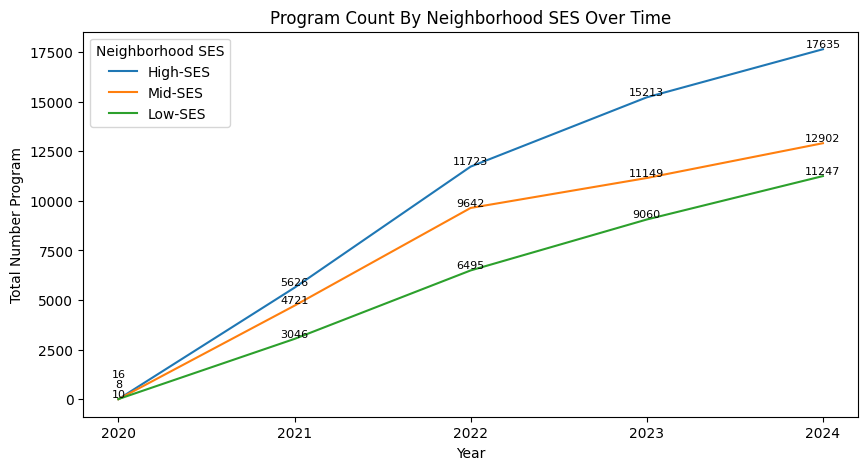

In [5]:
#| echo: false
# merge MCMF dataset with neighborhood ses
project_by_year_by_ses=pd.merge(project_data,chi_ses,left_on="Neighborhood",right_on="COMMUNITY AREA NAME")
# exclude 2025 data
project_by_year_by_ses=project_by_year_by_ses[project_by_year_by_ses['Start Year']!=2025]
# count distinct programs based on ses & year
year_nei_programcount=project_by_year_by_ses.groupby(['Start Year','ses_bin'])['Program ID'].nunique().reset_index()
year_nei_programcount=year_nei_programcount.rename(columns={'Program ID':'Program Count'})
pivotdf=year_nei_programcount.pivot(index='Start Year',columns='ses_bin',values='Program Count')
# create lineplot of program coun by neighborhood ses over time
plt.figure(figsize=(10,5))
for ses in pivotdf.columns:
    plt.plot(pivotdf.index,pivotdf[ses], label=ses)
    for year,count in zip(pivotdf.index,pivotdf[ses]):
        if year == 2020:
            offset = 500 * (pivotdf.columns.tolist().index(ses) + 1)
            plt.text(year, count + offset, str(count), fontsize=8, ha='center', va='top')
        else:
            plt.text(year, count, str(count), fontsize=8, ha='center', va='bottom')
plt.title("Program Count By Neighborhood SES Over Time")
plt.xlabel("Year")
plt.ylabel("Total Number Program")
plt.xticks(ticks=pivotdf.index)
plt.legend(title="Neighborhood SES")
plt.show()

Now, we can clearly see that, in general, the number of distinct programs increases across all three SES buckets over the years, with high-SES neighborhoods showing the highest rate of increase. From 2022 to 2024, the total number of programs in low-SES neighborhoods is gradually approaching that of mid-SES neighborhoods. This suggests that, while a gap still exists in the number of programs offered across SES buckets, efforts are being made to bridge the equity gap in program availability.

I plotted a boxplot to further examine the distribution of programs among Neighborhood within each SES buckets. As shown below, high-SES bucket generally have more scattered distribution especially in year 2023 and 2024. Similarly, mid-SES and high-SES made up of most outliers, indicating that certain mid- or high-SES neighborhood far more programs than most other neighborhood. After sorting the values of program count, I found that Irving Park, Near West Side, Morgan Park, Loop, and Lincoln Square are the five neighborhood with top number of program count, with Irving Park neighborhood consistantly having most amount of programs each year than all other neighborhood. 

I looked into other factors to deduce the reasons why these five neighborhood have most amount of programs. I found that 4/5 of the neighborhoods locate in or near chicago downtown area, so it could be that since people are more likely to come out to downtown, neighborhood in downtown areas assume that they are serving both people living in the area and those who might work/come visit the downtown area.

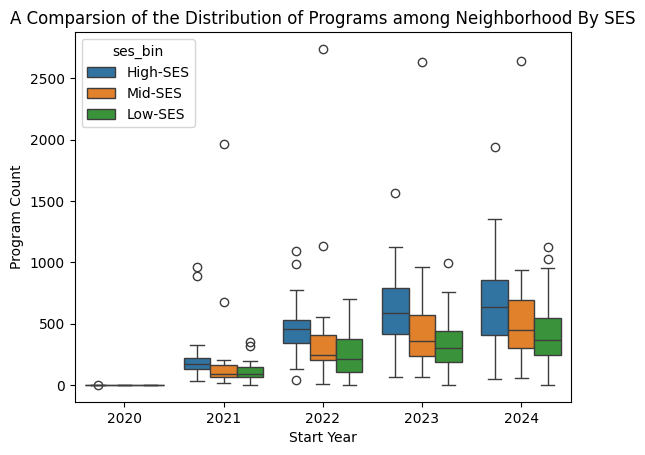

In [8]:
#| echo: false
# count distinct programs by neighborhood and year
pivot_distro_data = (
    project_by_year_by_ses
    .groupby(['Start Year', 'Neighborhood'])['Program ID']
    .nunique()
    .reset_index()
    .rename(columns={'Program ID':'Program Count'})
)
pivot_distro_data = pivot_distro_data.merge(
    project_by_year_by_ses[['Start Year', 'Neighborhood', 'ses_bin']].drop_duplicates(),
    on=['Start Year', 'Neighborhood'],
    how='left'
)
# create side-by-side boxplot
sns.boxplot(pivot_distro_data,x='Start Year',y='Program Count',hue='ses_bin').set_title('A Comparsion of the Distribution of Programs among Neighborhood By SES')
plt.show()
# show the top 10 neighborhood with top program count
# pivot_distro_data.sort_values(by='Program Count',ascending=False).head(10)

Then, I looked into the distribution of programs with equity features (Scholarship Available, has free food, participants paid) among three SES buckets over the years. As shown below, programs that offer scholarship are more distributed in high-SES neighborhood and programs that has free food are more distributed in low-SES neighborhood especially in 2023 and 2024. There's not a clear pattern of how programs that pays participants are distributed, but high- and mid-SES neighborhoods have relatively more paid programs. Free food programs also increase among all three neighborhood SES buckets over time. To further explore factors that contribute to this general distributions, I decided to look into each equity features.

/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/3596593404.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ses_bin', 'Start Year'])
/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/3596593404.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ses_bin', 'Start Year'])
/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/3596593404.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

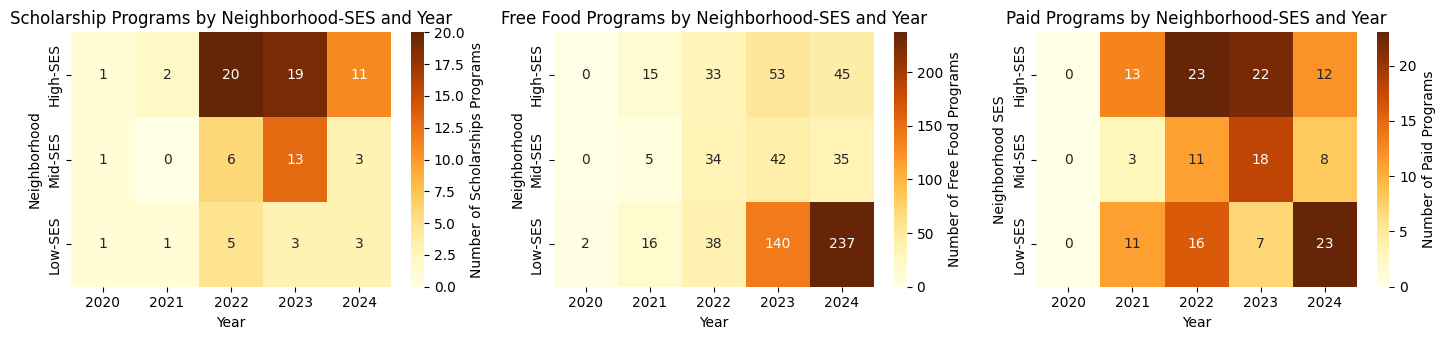

In [9]:
#| echo: false
# definition a function to create heatmap based on ses and year
def generate_heatmap(data, title, label, col_label, row_label, ax):
    heatmap_data = data.pivot(index='ses_bin', columns='Start Year', values='Offers').fillna(0)
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlOrBr", cbar_kws={'label': label}, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(col_label)
    ax.set_ylabel(row_label)
fig, axes = plt.subplots(1,3, figsize=(14.5, 3.5))
# Scholarship Heatmap
scholarship_offers_by_neises = (
    project_by_year_by_ses[project_by_year_by_ses['Scholarship Available'] == True]
    .groupby(['ses_bin', 'Start Year'])
    .agg(Offers=('Program ID', 'nunique'))
    .reset_index()
)
generate_heatmap(scholarship_offers_by_neises, "Scholarship Programs by Neighborhood-SES and Year", 
                 "Number of Scholarships Programs", "Year", "Neighborhood", axes[0])
# Free Food Heatmap
freefood_by_neises = (
    project_by_year_by_ses[project_by_year_by_ses['Has Free Food'] == True]
    .groupby(['ses_bin', 'Start Year'])
    .agg(Offers=('Program ID', 'nunique'))
    .reset_index()
)
generate_heatmap(freefood_by_neises, "Free Food Programs by Neighborhood-SES and Year", 
                 "Number of Free Food Programs", "Year", "Neighborhood", axes[1])
# Paid Programs Heatmap
paid_offers_by_neises = (
    project_by_year_by_ses[project_by_year_by_ses['Participants Paid'] == 'Paid, Type Unknown']
    .groupby(['ses_bin', 'Start Year'])
    .agg(Offers=('Program ID', 'nunique'))
    .reset_index()
)
# deal with no paid program 2020
fillna2020 = pd.DataFrame({
    'ses_bin': ['High-SES', 'Mid-SES', 'Low-SES'],
    'Start Year': [2020, 2020, 2020],
    'Offers': [0, 0, 0]
})
paid_offers_by_neises = pd.concat([paid_offers_by_neises, fillna2020], ignore_index=True)
ses_order = ['High-SES', 'Mid-SES', 'Low-SES']
paid_offers_by_neises['ses_bin'] = pd.Categorical(paid_offers_by_neises['ses_bin'], categories=ses_order, ordered=True)
paid_offers_by_neises=paid_offers_by_neises.sort_values(by=['ses_bin', 'Start Year']).reset_index(drop=True)
generate_heatmap(paid_offers_by_neises, "Paid Programs by Neighborhood-SES and Year", 
                 "Number of Paid Programs", "Year", "Neighborhood SES", axes[2])
plt.tight_layout()
plt.show()

#### Equity Feature: Scholarship Available

Since academic programs are the one typically offers scholarship, my assumption for the trend that high-SES neighborhood has more scholarship programs is that there are more academic programs offered in high-SES neighborhood. To validate this assumption, I further seperate programs by their categories. However, the original dataset has too many categories and multiple categories belong to academic programs. Therefore, I grouped categories together into four buckets: Career & Life Skills, STEM & Writing, Arts & Humanity, Sports & Wellbeing. Among them, STEM & Writing and Arts & Humanity are academic programs. The reason why I group STEM and Writing together is because they are both considered critical in influencing one's academic performance, especially for higher education. After visualizing in a clustered bar graph, I found that High-SES neighborhood, indeed, have more academic programs, both STEM & Writing and Arts & Humanity. Additionally, high-SES neighborhoods have more scholarship programs in every categories than mid-SES neighborhoods and low-SES neighborhoods, indicating a severe financial inequity among programs. 

/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/858058547.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ses_category_programcount = project_by_year_by_ses[project_by_year_by_ses['Scholarship Available']==True].loc[:,['Program ID','Category Group','ses_bin']].groupby(


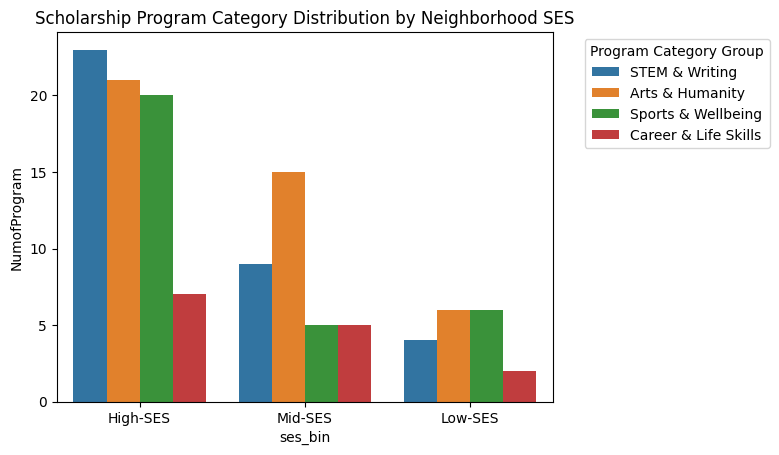

In [10]:
#| echo: false
# group program categories
project_by_year_by_ses['Category Group']=project_by_year_by_ses['Category Name'].map(
    {
       'Work + Career':'Career & Life Skills', 
       'Managing Money.':'Career & Life Skills', 
       'Reading & Writing.':'STEM & Writing',
       'Music & Art.':'Arts & Humanity', 
       'Sports + Wellness.':'Sports & Wellbeing', 
       'Science':'STEM & Writing', 
       'Food.':'Sports & Wellbeing',
       'Academic Support':'STEM & Writing', 
       'Digital Media.':'Arts & Humanity', 
       'Performance.':'Arts & Humanity', 
       'Healthcare':'Sports & Wellbeing',
       'Social Studies':'Arts & Humanity', 
       'Computers.':'STEM & Writing', 
       'Math':'STEM & Writing', 
       'Helping Your Community.':'Arts & Humanity',
       'Building & Fixing Things':'Career & Life Skills', 
       'Nature.':'Sports & Wellbeing', 
       'Teaching':'Career & Life Skills',
       'Customer/Human Service':'Career & Life Skills', 
       'Transportation':'Career & Life Skills', 
       'Law':'Career & Life Skills'
    }
)
# count distinct programs based on ses and category
ses_category_programcount = project_by_year_by_ses[project_by_year_by_ses['Scholarship Available']==True].loc[:,['Program ID','Category Group','ses_bin']].groupby(
    ['ses_bin','Category Group']
    ).agg(
        NumofProgram=('Program ID', 'nunique')
        ).reset_index().sort_values(by=['ses_bin', 'NumofProgram'], ascending=[True, False])
# side-by-side barplot of scholarship program category distribution by SES
sns.barplot(ses_category_programcount,x='ses_bin',y='NumofProgram',hue='Category Group').set_title('Scholarship Program Category Distribution by Neighborhood SES')
plt.legend(title='Program Category Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Equity Feature: Has Free Food

While the general trend shows that low-SES neighborhood has more free food programs, I want to look more closer into each neighborhood, not just on the broad SES level. For example, for neighborhoods within low-SES buckets, is there a equal distribution of free food programs? On the neighhborhood level, can we still observe a positive correlation between neighborhood hardship index and number of free food programs offered. Therefore, I plotted a scatterplot with trendline with each neighborhood as a datapoint.

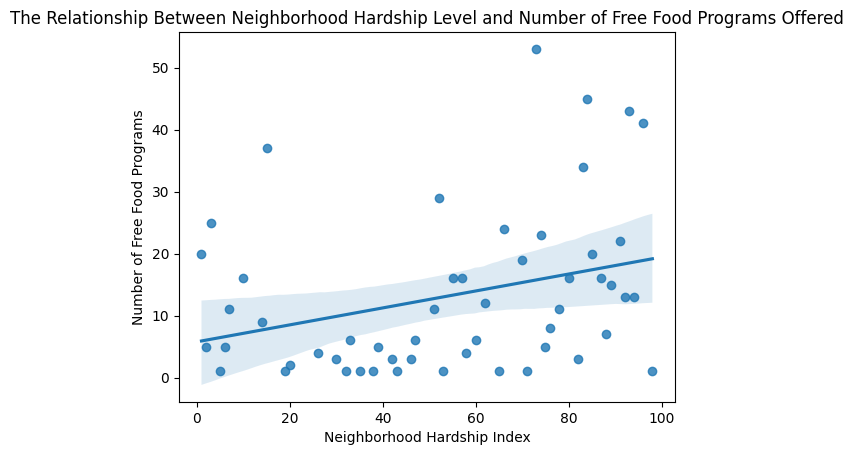

In [13]:
#| echo: false
# count freefood programs by neighborhood
freefood_by_nei = (
    project_by_year_by_ses[project_by_year_by_ses['Has Free Food'] == True]
    .groupby(['Neighborhood'])
    .agg(Offers=('Program ID', 'nunique'))
    .reset_index()
)
# merge the previous dataset to get hardship index for each neighborhood
freefood_by_nei=freefood_by_nei.merge(project_by_year_by_ses[['HARDSHIP INDEX','ses_bin','Neighborhood']].drop_duplicates(),on='Neighborhood')
# plot scatter with trendline
sns.regplot(freefood_by_nei,x='HARDSHIP INDEX',y='Offers')
plt.xlabel('Neighborhood Hardship Index')
plt.ylabel('Number of Free Food Programs')
plt.title('The Relationship Between Neighborhood Hardship Level and Number of Free Food Programs Offered')
plt.show()
# find the top and bottom neighborhood with free food programs
# freefood_by_nei.sort_values(by='Offers',ascending=False).head(10)
# freefood_by_nei.sort_values(by='Offers',ascending=False).tail(10)

The result showcases a mild positive correlation between neighborhood hardship index and number of free food programs, meaning that neighborhood that has mroe hardship indeed has more free food programs. However, we can observe several extreme high values, indicating that these several neighborhood has far more free food programs than most others. So I sorted the dataset by number of free food programs offered and found that Austin, Brighton Park, Gage Park, South Lawndale, Near West Side are the five neighborhoods with most free food programs. I found that Austin has a large population than most neighborhood which could account for its relatively large amount of free food programs. Additionally, among these top five neighborhood, Near West Side is a high-SES neighborhood. Since it is near downtown, it makes sense to have more free food programs as downtown generally have more active population. However, many low-SES neighborhood are located at the south side of Chicago, making it logitically hard to get to downtown area like Near West Side than other neighborhoods near downtown (which typically are mid- and high-SES neighborhoods). Furthermore, considering some neighborhood with very high hardship level has very few free food programs (for example, Riverdale, a neighborhood that has the second highest hardship level only have 1 free food programs over the years), we can conclude that there is still shows a sizable food inequity despite the general trend of low-SES neighborhood having more free food programs. 

#### Equity Feature: Participants Paid

For participants paid variable, since there is not a detectable differences among the three neighborhood SES buckets and I noticed that many programs' participants paid variable has NaN values. Therefore, I want to try to improve the data quality. Specifically, I wonder if some programs, in fact, pay their participants, but show up as unpaid or NaN. To do so, I first investigate the word frequency in the descriptions of programs that pay participants. This is to identify key words in these paid programs that relate to financial support. Using re, nltk and counter libraries, I was able to remove stopwords and unreable parts,  parse descriptions into words, and count the number of times each words appear. As shown in the graph below, among the top 20 most common words, "paid" and "stipend" are the two that are related to financial support. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dxchannel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dxchannel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dxchannel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


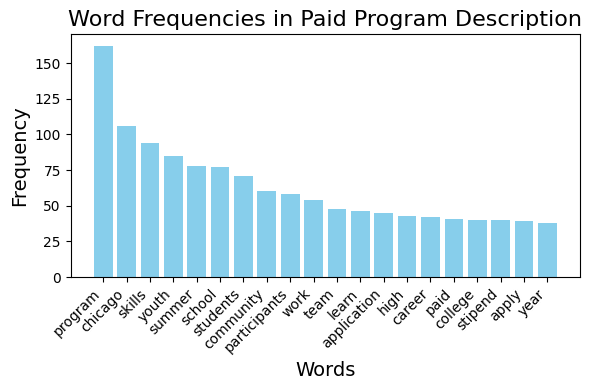

In [14]:
#| echo: false
# get all paid programs
paid_programs=project_by_year_by_ses[project_by_year_by_ses['Participants Paid'] == 'Paid, Type Unknown'].loc[:,['Program ID','Description','Org Name']]
paid_programs=paid_programs.set_index('Program ID').drop_duplicates()
# download relevant nltk packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
# create a function that clean and slice descriptions by word
def description_cleaner(description):
    cleaned_description = re.sub(r'<.*?>', '', description)
    words = word_tokenize(cleaned_description.lower())
    return [word for word in words if word not in stop_words and word.isalpha()]
# create a column that store clean description (list of words)
paid_programs['Cleaned_Description']=paid_programs['Description'].apply(description_cleaner)
# get all words from all descriptions
all_words = [word for description in paid_programs['Cleaned_Description'] for word in description]
# count word frequency
word_counts = Counter(all_words)
# Get the most common words
common_words = word_counts.most_common(20) 
# plot a bar graph to show word frequency
word, frequency = zip(*common_words)
plt.figure(figsize=(6, 4))
plt.bar(word, frequency, color='skyblue')
plt.title('Word Frequencies in Paid Program Description', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.tight_layout() 
plt.show()

Next, I decided to identify program descriptions that has either of these two key words "paid" and "stipend" but labelled as "unpaid" or NaN in "participants paid" column and labelled as false in "scholarship available" column. In this way, I hope to find programs that pay participants but did not show up as paid program or scholarship program. 

To ensure the keywords accurately reflect that the program compensates its participants, I used re library to parse the descriptions into sentences and identify those containing the words "paid" or "stipend". Upon reviewing the matching sentences, I found that all instances of "stipend" reliably indicated programs that pay their participants. However, the keyword "paid" introduced noise, such as mentions of "paid parking." To reduce false positives, I chose to use "stipend" as the sole indicator of a paid program. I then added a new column, "Stipend", and marked programs offering stipends as True.

Finally, I created a updated heatmap counting programs that either has "Paid, Type Unknown" value in "Participants Paid" column or True in "Stipend" column. Through a side by side comparsion of the previous heatmap and this updated version, we can observe that the number of programs that pay participants significantly increase in 2024 for low-SES neighborhoods. By comparing the two graph, we can also see that there are many programs that pay participants through stipend but is not labeled in the "pariticipants paid" column for low-SES neighborhoods but not that much for mid- and high-SES neighborhoods. This suggests that while efforts to provide financial supports for low-SES neighborhood have improved, these opportunities are not being adequately advertised. 

/var/folders/d0/lnkwf311481bj1nhh21x9k3m0000gn/T/ipykernel_3244/1407071438.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ses_bin', 'Start Year'])


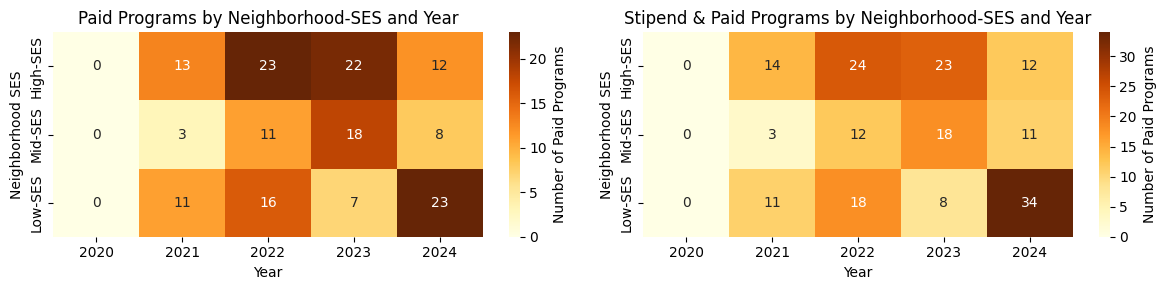

In [15]:
#| echo: false
# create a function that slice description into sentences
def sentence_seperator(description,word):
    cleaned_description = re.sub(r'<.*?>', '', description)
    sentences = re.split(r'(?<=[.!?])', cleaned_description)
    return [sentence for sentence in sentences if word.lower() in sentence.lower()]
# find the sentences in descriptions that contain the word "paid"
paidword_program=project_by_year_by_ses[project_by_year_by_ses['Description'].str.contains('paid', case=False, na=False)]
paidword_program=paidword_program.loc[:,['Program ID','Program Name', 'Description','COMMUNITY AREA NAME','Scholarship Available','Participants Paid']]
paidword_program=paidword_program.set_index('Program ID').drop_duplicates()
not_labeled_paidword_program=paidword_program[(paidword_program['Participants Paid'] != 'Paid, Type Unknown') & (paidword_program['Scholarship Available'] == False)]
not_labeled_paidword_program.loc[:,['Matching Sentences']] = not_labeled_paidword_program['Description'].apply(lambda desc: sentence_seperator(desc,'paid'))
# display five samples of sentence that contains "paid" to inspect whether it actually reflects that the program pays participants
pd.set_option('display.max_colwidth', None)
not_labeled_paidword_program.loc[:,['Matching Sentences']].sample(5)
# find the sentences in descriptions that contain the word "stipend"
stipend_program=project_by_year_by_ses[project_by_year_by_ses['Description'].str.contains('stipend', case=False, na=False)]
stipend_program=stipend_program.loc[:,['Program ID','Program Name', 'Description','COMMUNITY AREA NAME','Scholarship Available','Participants Paid']]
stipend_program=stipend_program.set_index('Program ID').drop_duplicates()
not_labeled_stipend_program=stipend_program[(stipend_program['Participants Paid'] != 'Paid, Type Unknown') & (stipend_program['Scholarship Available'] == False)]
not_labeled_stipend_program.loc[:,['Matching Sentences']] = not_labeled_stipend_program['Description'].apply(lambda desc: sentence_seperator(desc, 'stipend'))
# display five samples of sentence that contains "stipend" to inspect whether it actually reflects that the program pays participants
not_labeled_stipend_program.loc[:,['Matching Sentences']].sample(5)
# create a column called stipend and impute it with true if has matching sentence 
project_by_year_by_ses.loc[
    project_by_year_by_ses['Program ID'].isin(not_labeled_stipend_program.index),
    'Stipend'
] = True
# count distinct paid programs based on ses and start year 
new_paid_offers_by_neises = (
    project_by_year_by_ses[(project_by_year_by_ses['Participants Paid'] == 'Paid, Type Unknown') | (project_by_year_by_ses['Stipend']==True)]
    .groupby(['ses_bin', 'Start Year'])
    .agg(Offers=('Program ID', 'nunique'))
    .reset_index()
)
new_paid_offers_by_neises = pd.concat([new_paid_offers_by_neises, fillna2020], ignore_index=True)
new_paid_offers_by_neises['ses_bin'] = pd.Categorical(new_paid_offers_by_neises['ses_bin'], categories=ses_order, ordered=True)
new_paid_offers_by_neises=new_paid_offers_by_neises.sort_values(by=['ses_bin', 'Start Year']).reset_index(drop=True)
# plot two heatmap to compare the result before and after imputing stipend programs
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

generate_heatmap(paid_offers_by_neises, "Paid Programs by Neighborhood-SES and Year", 
                 "Number of Paid Programs", "Year", "Neighborhood SES", axes[0])

generate_heatmap(new_paid_offers_by_neises, "Stipend & Paid Programs by Neighborhood-SES and Year", 
                 "Number of Paid Programs", "Year", "Neighborhood SES", axes[1])

plt.tight_layout()
plt.show()

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

In conclusion, analysis 2 reveals ongoing inequities in program availability and support across SES buckets, despite some positive trends. High-SES neighborhoods consistently have greater access to academic programs and scholarships. While low-SES neighborhoods generally have more free food programs, the uneven distribution within these areas—where neighborhoods with high hardship levels like Riverdale remain underserved—reveals persistent logistical and structural challenges. Similarly, the prevalent mislabeled or under-advertised stipend opportunities in low-SES neighborhoods highlights the importance of improving program transparency and marketing. By addressing these gaps, stakeholders can better align resources with community needs, ensuring that equity-focused efforts reach the populations that need them most.

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

My Chi My Future initiative leadership should consider direct organizers in Irving Park, Near West Side, Morgan Park, and Lincoln Square to hold more programs in low-SES neighborhoods that are far away from downtown area, as these four neighborhood has the most amount of programs over the years. MCMF leadership should consider encourage more academic programs (both STEM & Writing and Arts & Humanity) in low-SES neighborhoods, and Program organizers should consider provide more scholarship options for low-SES neighborhoods or provide scholarship based on needs. MCMF leadership should also encourage more program organizers to provide free food options for low-SES neighborhoods. Finally, MCMF leadership should feature or promote programs that are hold in low-SES neighborhood and pay participants. Program organizers should put more effort in marketing if their programs pay participants by accurately inputing information in the "Participants Paid" column, not just in description. On the other hand, when collecting information, MCMF leadership should consider puting equity-focused features (scholarship available, has free food, participants paid) in front so that program organizers do not forget to fill them out. If possible, MCMF leadership should consider building a data screening tool that scans program descriptions and extract information related to equity-focus features (such as the amount of stipend provided). 

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.